# Dataset exploration

In this notebook we analyse the structure and properties of train and test datasets.

Three datasets are provided in [HDF5](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) format: 
* `quality_dataset.h5` is the train dataset with 137,030 samples. Each sample represents 2 `s` of a single EEG channel recording sampled at 250 `Hz` (yielding 500 data points per sample), and is labelled 0 for *bad quality* or 1 for *good quality*.
* `record1.h5` is a test dataset containing a single sample with 4 EEG channels and is partially labelled.
* `record2.h5` is a test dataset also containing a single sample with 4 EEG channels.

All datasets contain both *raw* and *filtered* version of EEG samples.

The structure of the datasets (up to 2nd level) can be displayed with the script `python/dataset_exploration.py`, and are shown below.

## Setup notebook environment
First import the modules needed for this notebook and setup matplotlib environment.

In [1]:
%matplotlib inline

from __future__ import division
import numpy as np
import sys
import os
import h5py
import random
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from palettable.tableau import TableauLight_10
from cycler import cycler

sys.path.append('../python')
from dataset_exploration import print_hdf5_data_shape

# setup matplotlib environment
from utils.myplt import plot_clean

plt.rcParams.update({'figure.figsize': (16, 7),
                     'lines.linewidth': 4,
                     'font.size': 14,
                     'font.family': 'serif'})

plt.rc('axes', prop_cycle=(cycler('color', TableauLight_10.mpl_colors)))

save_figs= False

## Inspect content of datasets
Display the shape of data in all datasets using the function `print_hdf5_data_shape` from `python/dataset_exploration.py`.

In [2]:
# root path for datasets and list of datasets
datasets_root = '../../datasets'
datasets = ["quality_dataset.h5", "record1.h5", "record2.h5"]

for item in datasets:
    path = os.path.join(datasets_root, item)
    
    print_hdf5_data_shape(path)

Dataset ../../datasets/quality_dataset.h5 contains:
   dataset: (137030, 1001)
   feature_descriptipn: (1001,)

Dataset ../../datasets/record1.h5 contains:
   accelerometer/x: (2279140,)
   accelerometer/y: (2279140,)
   accelerometer/z: (2279140,)
   accelerometer_interruption: (57,)
   alarm_clock: (0,)
   channel1/filtered: (11395705,)
   channel1/raw: (11395705,)
   channel1/visualization: (11395705,)
   channel2/filtered: (11395705,)
   channel2/raw: (11395705,)
   channel2/visualization: (11395705,)
   channel3/filtered: (11395705,)
   channel3/raw: (11395705,)
   channel3/visualization: (11395705,)
   channel4/filtered: (11395705,)
   channel4/raw: (11395705,)
   channel4/visualization: (11395705,)
   reporting/hypnograms: (1519,)
   reporting/mother_curve_sham: (1000,)
   reporting/mother_curve_stim: (1000,)
   reporting/movements: (50,)
   reporting/stimulations_reporting: (12,)
   stimulations/stimulations: (12,)
   stimulations/stimulations_intensity: (12,)
   stimulations/s

The location of *raw* and *filtered* samples in `quality_dataset.h5` are labelled `raw_N`, `filtered_N` with $N\in\{0,\ldots, 499\}$.

In [3]:
path = os.path.join(datasets_root, 'quality_dataset.h5')
with h5py.File(path, 'r') as f:
    
    # 'feature_descriptipn' data
    features = f['feature_descriptipn'][:]
    
    print features

['raw_0' 'raw_1' 'raw_2' ..., 'filtered_498' 'filtered_499' 'label']


The location `raw`, `filtered` samples and `labels` can be obtained as follows:

In [4]:
path = os.path.join(datasets_root, 'quality_dataset.h5')
with h5py.File(path, 'r') as f:

    # 'feature_descriptipn' data
    features = f['feature_descriptipn'][:]
    
    # extract common string in feature names
    features_type = [item.split('_')[0] for item in features]
    
    # extract unique common string in feature names
    features_type_set = set(features_type)
    
    print 'Label types:', ', '.join(features_type_set)
    
    # locate first location of common strings and display full feature name
    print '\n', 'Label type locations:'
    for label in features_type_set:
        print next((idx, features[idx]) for idx, item in enumerate(features_type) 
                                        if item == label)

Label types: raw, label, filtered

Label type locations:
(0, 'raw_0')
(1000, 'label')
(500, 'filtered_0')


## Import train dataset
The contents of `quality_dataset.h5` are saved to ```numpy``` arrays ```raw```, ```filtered``` and ```labels```.

In [5]:
path = os.path.join(datasets_root, 'quality_dataset.h5')
with h5py.File(path, 'r') as f:

    # Extract raw signal
    raw = np.array(f['dataset'][:, :500])

    # Extract filtered signal
    filtered = np.array(f['dataset'][:, 500:1000])

    # Extract labels
    labels = np.array(f['dataset'][:, 1000])

## Visualize samples from train dataset
Visualize first few samples from `raw` and `filtered` EEG signals.

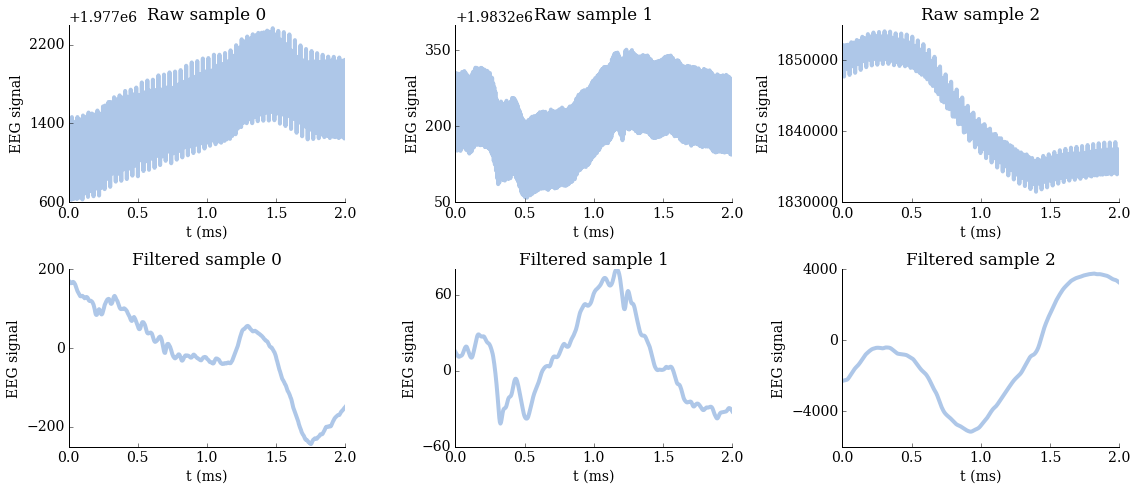

In [6]:
gs = GridSpec(2, 3)

for idx in range(3):
    
    sample = raw[idx, :]
    range_x = np.linspace(0, 2, num=len(sample))
    
    plt.subplot(gs[0, idx]) 
    plt.plot(range_x, sample)
    
    plt.xlabel('t (ms)')
    plt.ylabel('EEG signal')
    plt.title('Raw sample ' + str(idx))
    plot_clean()
    
    sample = filtered[idx, :]
    
    plt.subplot(gs[1, idx]) 
    plt.plot(range_x, sample)
    
    plt.xlabel('t (ms)')
    plt.ylabel('EEG signal')
    plt.title('Filtered sample ' + str(idx))
    plot_clean()
    
plt.tight_layout()
if save_figs:
    plt.savefig("../images/samples.png", format='png')

Visualize *bad quality* and *good quality* samples. This cell randomly selects samples to display.

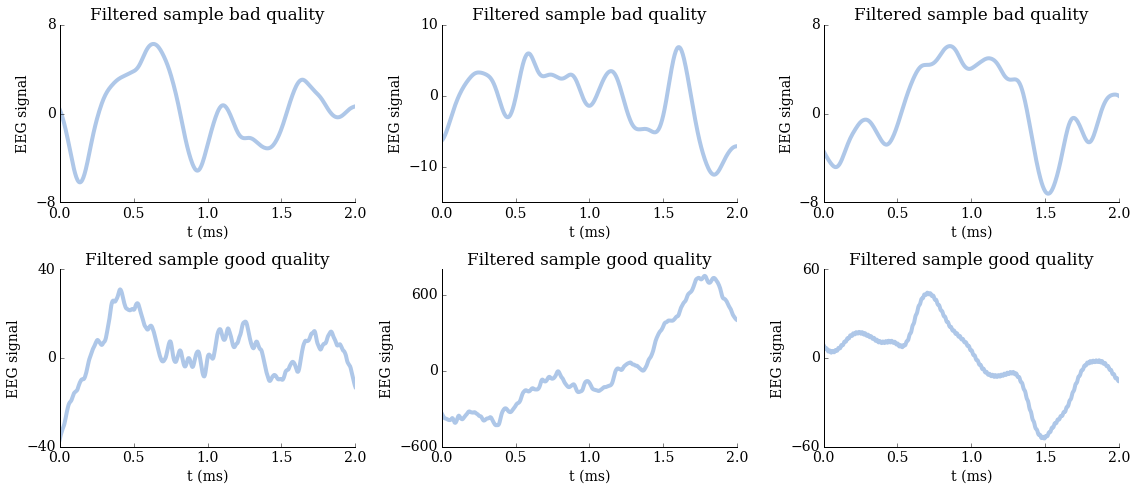

In [7]:
gs = GridSpec(2, 3)

# filtered samples with label=0 and 3 randomly selected indexes
samples_bad = filtered[labels==0]
samples_bad_n = len(samples_bad)
samples_bad_idx = random.sample(range(samples_bad_n), 3)

# filtered samples with label=1 and 3 randomly selected indexes
samples_good = filtered[labels==1]
samples_good_n = len(samples_good)
samples_good_idx = random.sample(range(samples_good_n), 3)

plt.figure()

row = 0
for samples, label in [[samples_bad[samples_bad_idx], 'bad quality'],
                       [samples_good[samples_good_idx], 'good quality']]:
    
    
    for idx, sample in enumerate(samples):
        
        range_x = np.linspace(0, 2, num=len(sample))

        plt.subplot(gs[row, idx]) 
        plt.plot(range_x, sample)

        plt.xlabel('t (ms)')
        plt.ylabel('EEG signal')
        plt.title('Filtered sample ' + label)
        plot_clean()
        
    row += 1
    
plt.tight_layout()
if save_figs:
    plt.savefig("../images/samples_label.png", format='png')

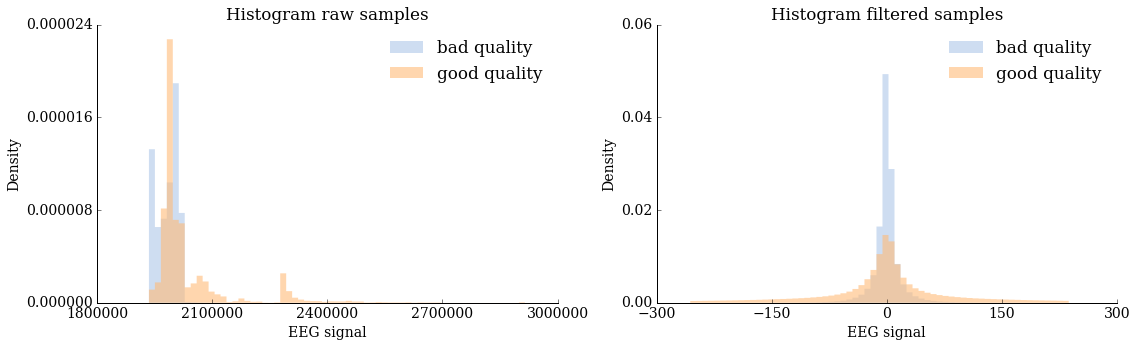

In [8]:
plt.rcParams.update({'figure.figsize': (16, 5)})

gs = GridSpec(1, 2)

raw_bins = np.linspace(np.percentile(raw, 5),
                       np.percentile(raw, 95), num=64)

filtered_bins = np.linspace(np.percentile(filtered, 5),
                            np.percentile(filtered, 95), num=64)
    
plt.figure()

for samples1, samples2, label in [[raw[labels==0], filtered[labels==0], 'bad quality'],
                                  [raw[labels==1], filtered[labels==1], 'good quality']]:


    plt.subplot(gs[0]) 
    plt.hist(samples1.flatten(), bins=raw_bins,
             normed=True, histtype='stepfilled',
             linewidth=0, alpha=0.6, label=label)

    plt.ylabel('Density')
    plt.xlabel('EEG signal')
    plt.title('Histogram raw samples')
    plt.legend(loc='upper right',frameon=False)
    plot_clean()
    
    plt.subplot(gs[1]) 
    pdf, bins, patches=plt.hist(samples2.flatten(), bins=filtered_bins,
             normed=True, histtype='stepfilled',
             linewidth=0, alpha=0.6, label=label)

    plt.ylabel('Density')
    plt.xlabel('EEG signal')
    plt.title('Histogram filtered samples')
    plt.legend(loc='upper right', frameon=False)
    plot_clean()
    
plt.tight_layout()
if save_figs:
    plt.savefig("../images/samples_hist.png", format='png')

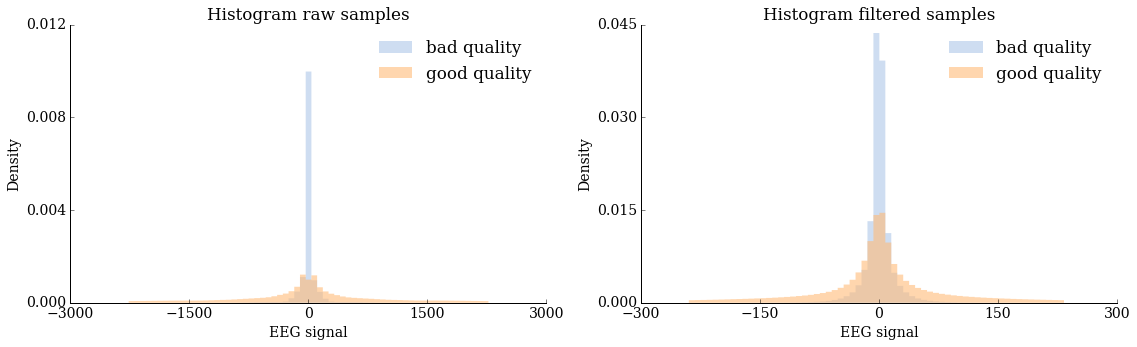

In [9]:
plt.rcParams.update({'figure.figsize': (16, 5)})

gs = GridSpec(1, 2)

raw_zm = raw - np.mean(raw, axis=1)[..., np.newaxis]
filtered_zm = filtered - np.mean(filtered, axis=1)[..., np.newaxis]

raw_bins = np.linspace(np.percentile(raw_zm, 5),
                       np.percentile(raw_zm, 95), num=64)

filtered_bins = np.linspace(np.percentile(filtered_zm, 5),
                            np.percentile(filtered_zm, 95), num=64)

plt.figure()

for samples1, samples2, label in \
    [[raw_zm[labels==0], filtered_zm[labels==0], 'bad quality'],
     [raw_zm[labels==1], filtered_zm[labels==1], 'good quality']]:
    
    plt.subplot(gs[0]) 
    plt.hist(samples1.flatten(), bins=raw_bins,
             normed=True, histtype='stepfilled',
             linewidth=0, alpha=0.6, label=label)

    plt.ylabel('Density')
    plt.xlabel('EEG signal')
    plt.title('Histogram raw samples')
    plt.legend(loc='upper right',frameon=False)
    plot_clean()
    
    plt.subplot(gs[1]) 
    pdf, bins, patches=plt.hist(samples2.flatten(), bins=filtered_bins,
             normed=True, histtype='stepfilled',
             linewidth=0, alpha=0.6, label=label)

    plt.ylabel('Density')
    plt.xlabel('EEG signal')
    plt.title('Histogram filtered samples')
    plt.legend(loc='upper right', frameon=False)
    plot_clean()
    
plt.tight_layout()
if save_figs:
    plt.savefig("../images/samples_hist_norm.png", format='png')